## MOVIE RATING PREDICTION WITH PYTHON 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Data Understanding and Exploration

In [3]:
data = pd.read_csv("IMDb Movies India.csv", encoding="latin1")

In [4]:
data.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
data.shape

(15509, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [7]:
# Getting insights of the features
data.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [8]:
# check missing values
round(100*(data.isna().sum()/len(data)),2)

Name         0.00
Year         3.40
Duration    53.32
Genre       12.10
Rating      48.94
Votes       48.93
Director     3.39
Actor 1     10.43
Actor 2     15.37
Actor 3     20.27
dtype: float64

In [9]:
# dropping rows of columns having missing values more than 40%
columns_above_40 = ["Duration", "Rating", "Votes"]
data.dropna(subset=columns_above_40, inplace=True)

In [10]:
round(100*(data.isna().sum()/len(data)),2)

Name        0.00
Year        0.00
Duration    0.00
Genre       0.53
Rating      0.00
Votes       0.00
Director    0.02
Actor 1     1.28
Actor 2     2.00
Actor 3     2.79
dtype: float64

In [11]:
# dropping the rows for columns having less 5% missing values
data.dropna(subset=["Director", "Actor 1", "Actor 2", "Actor 3"], inplace=True)

In [12]:
# Fill missing values in 'Genre' with its mode
genre_mode = data['Genre'].mode()[0]
data['Genre'].fillna(genre_mode, inplace=True)

In [13]:
data.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [14]:
data.shape

(5688, 10)

In [15]:
data['Votes'].unique()

array(['8', '35', '827', ..., '70,344', '408', '1,496'], dtype=object)

In [16]:
# display unique values for each column
unique_values_preview = pd.DataFrame({
    'Column Name': data.columns,
    'Unique Count': [data[col].nunique() for col in data.columns],
    'Sample Unique Values': [data[col].dropna().unique()[:5] for col in data.columns]  
})

unique_values_preview = unique_values_preview.sort_values(by='Unique Count')

print(unique_values_preview)

  Column Name  Unique Count                               Sample Unique Values
4      Rating            83                          [7.0, 4.4, 4.7, 7.4, 5.6]
1        Year            91           [(2019), (1997), (2005), (2012), (2014)]
2    Duration           174       [109 min, 110 min, 147 min, 142 min, 82 min]
3       Genre           376  [Drama, Comedy, Romance, Comedy, Drama, Musica...
7     Actor 1          1974  [Rasika Dugal, Prateik, Bobby Deol, Jimmy Shei...
5       Votes          2027                           [8, 35, 827, 1,086, 326]
8     Actor 2          2336  [Vivek Ghamande, Ishita Raj, Aishwarya Rai Bac...
6    Director          2438  [Gaurav Bakshi, Ovais Khan, Rahul Rawail, Shoo...
9     Actor 3          2572  [Arvind Jangid, Siddhant Kapoor, Shammi Kapoor...
0        Name          5410  [#Gadhvi (He thought he was Gandhi), #Yaaram, ...


In [17]:
data.drop(columns= 'Name', inplace =True)

In [18]:
# Remove parentheses from the 'Year' column
data['Year'] = data['Year'].str.replace(r"[()]", "", regex=True).astype(int)

# Remove "min" from the 'Duration' column
data['Duration'] = data['Duration'].str.replace(" min", "").astype(float)

# Remove commas from the 'Votes' column and convert to integers
data['Votes'] = data['Votes'].str.replace(",", "").astype(int)

In [19]:
data.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [20]:
data.dtypes

Year          int32
Duration    float64
Genre        object
Rating      float64
Votes         int32
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [21]:
data.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.99])

,Year,Duration,Rating,Votes
count,5688.000000,5688.000000,5688.000000,5688.000000
mean,1996.037623,133.486639,5.900738,2683.977848
std,19.977576,25.312671,1.379355,13617.991770
min,1931.000000,21.000000,1.100000,5.000000
25%,1982.000000,119.000000,5.000000,30.000000
50%,2001.000000,135.000000,6.100000,128.000000
75%,2013.000000,150.000000,6.900000,910.750000
90%,2018.000000,164.000000,7.500000,5094.800000
99%,2021.000000,190.000000,8.600000,45114.480000
max,2021.000000,321.000000,10.000000,591417.000000


In [22]:
# check if any duplicates in our DataFrame to ensures data quality and integrity
data.duplicated().sum()

0

In [23]:
data.columns

Index(['Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1',
       'Actor 2', 'Actor 3'],
      dtype='object')

### EDA

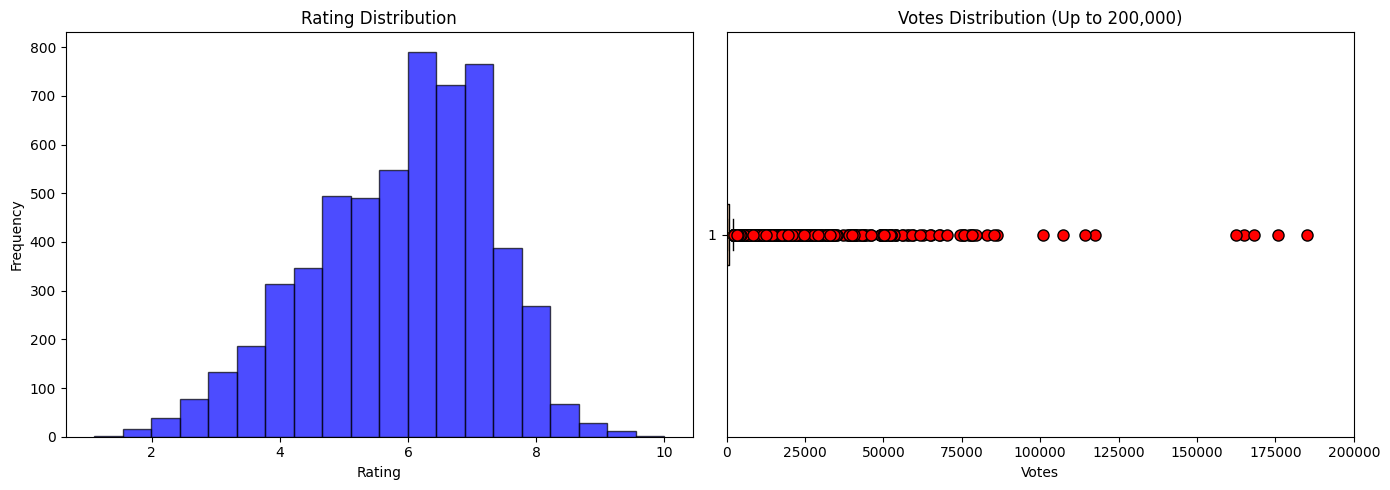

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating
axes[0].hist(data['Rating'], bins=20, color='blue',alpha = 0.7, edgecolor='black')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

# Votes
axes[1].boxplot(data['Votes'], vert=False, flierprops=dict(markerfacecolor='red', marker='o', markersize=8))
axes[1].set_title('Votes Distribution (Up to 200,000)')
axes[1].set_xlabel('Votes')
axes[1].set_xlim(0, 200000)

plt.tight_layout()
plt.show()

-  The rating distribution appears to be roughly bell-shaped, with the majority of movies receiving ratings around the 6-7 range. This suggests that most movies tend to receive average to slightly above-average ratings.
-  The boxplot shows that the majority of movies have less than 20,000 votes, with a few outliers having significantly more votes.The presence of outliers suggests that there might be some extremely popular movies that have garnered a large number of votes.

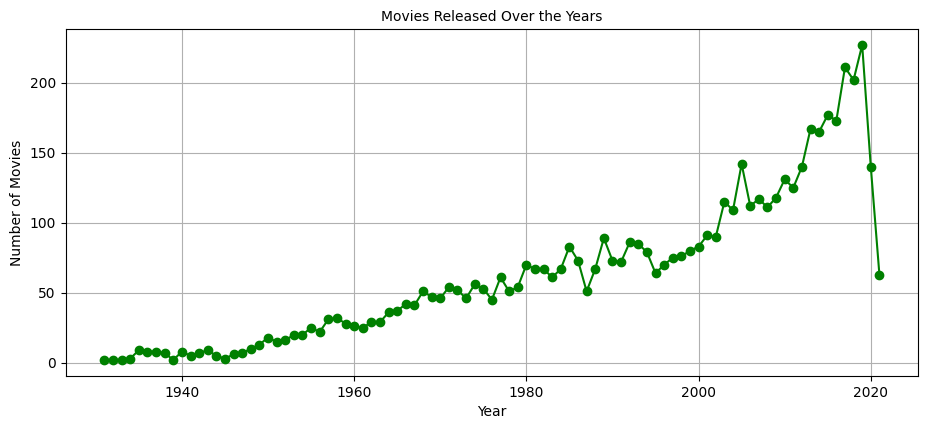

In [25]:
movies_per_year = data['Year'].value_counts().sort_index()

plt.figure(figsize=(11, 4.5))
movies_per_year.plot(kind='line', marker='o', color='green')
plt.title('Movies Released Over the Years', fontsize=10)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

-  The plot shows a clear upward trend in the number of movies released over the years. This indicates that the movie industry has grown significantly over time.

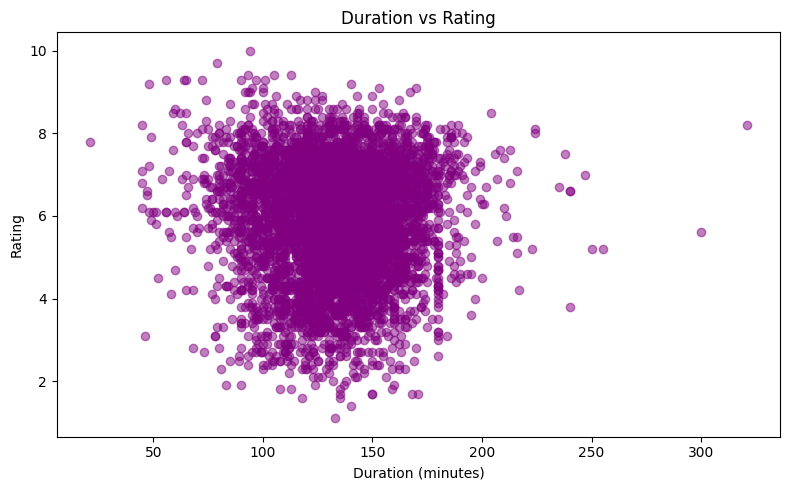

In [26]:
plt.figure(figsize=(8, 5))
plt.scatter(data['Duration'], data['Rating'], alpha=0.5, color='purple')

plt.title('Duration vs Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

-  The scatter plot shows no clear linear relationship between movie duration and rating. This suggests that the duration of a movie is not a strong predictor of its rating.
-  Most movies seem to be clustered around an average duration of 100-150 minutes, with a wide range of ratings within this duration range.

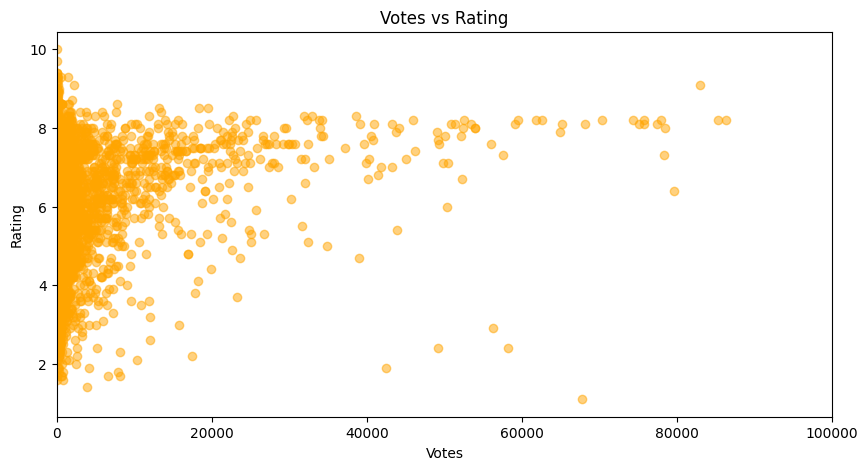

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(data['Votes'], data['Rating'], alpha=0.5, color='orange')
plt.title('Votes vs Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.xlim(0, 100000)
plt.show()

-  There seems to be a slight positive correlation between the number of votes a movie receives and its rating. This suggests that movies with more votes tend to have higher ratings.
-  However, even for movies with a less number of votes, there is a wide range of ratings. This indicates that the number of votes is not a perfect predictor of a movie's rating.

In [28]:
# group by Director to get the movie count and average rating
dir_stats = data.groupby('Director').agg(movie_count=('Rating', 'size'),avg_rating=('Rating', 'mean')).reset_index()

dir_stats_abv_7 = dir_stats[dir_stats['avg_rating'] > 7]

dir_stats_sorted = dir_stats_abv_7.sort_values(by='movie_count', ascending=False)
print(dir_stats_sorted)

                    Director  movie_count  avg_rating
734     Hrishikesh Mukherjee           33    7.266667
2065           Shyam Benegal           22    7.250000
669                   Gulzar           17    7.552941
349              B.R. Chopra           15    7.006667
236           Anurag Kashyap           13    7.400000
...                      ...          ...         ...
936            Kamal Swaroop            1    7.100000
926   Kamakhya Narayan Singh            1    7.800000
904               K.P. Singh            1    8.300000
894            K. Thankappan            1    7.100000
2432          Zeishan Quadri            1    7.200000

[434 rows x 3 columns]


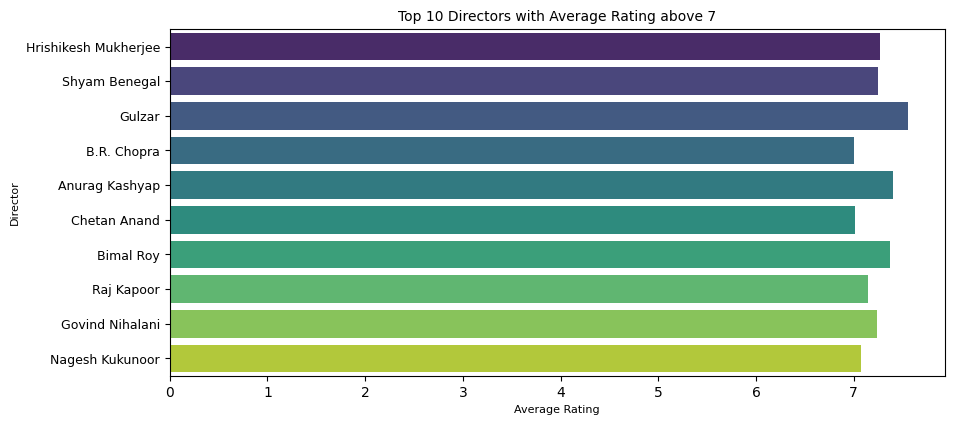

In [29]:
top_10_directors = dir_stats_sorted.head(10)

plt.figure(figsize=(10, 4.5))
sns.barplot(x='avg_rating', y='Director', data=top_10_directors, palette='viridis')

plt.title('Top 10 Directors with Average Rating above 7', fontsize=10)
plt.xlabel('Average Rating', fontsize=8)
plt.ylabel('Director', fontsize=8)
plt.yticks(fontsize=9)

plt.show()

In [30]:
# Group by genre to get the movie count and average rating
genre_stats = data.groupby('Genre').agg(movie_count=('Rating', 'size'),avg_rating=('Rating', 'mean')).reset_index()

# Filter genre with average rating greater than 7
genre_stats_filtered = genre_stats[(genre_stats['avg_rating'] > 7) & (genre_stats['movie_count'] > 1)]

# Sort by movie count in descending order
genre_stats_sorted = genre_stats_filtered.sort_values(by='movie_count', ascending=False)

print(genre_stats_sorted)

                           Genre  movie_count  avg_rating
215                  Documentary           25    7.760000
221           Documentary, Drama            5    7.100000
128     Biography, Comedy, Drama            5    7.240000
129      Biography, Crime, Drama            4    7.450000
224         Documentary, History            4    7.950000
249         Drama, Family, Sport            3    7.400000
275       Drama, Musical, Family            3    7.533333
197          Crime, Drama, Music            3    7.600000
327               Music, Romance            2    8.250000
293      Drama, Thriller, Action            2    7.300000
285       Drama, Romance, Family            2    7.200000
253       Drama, Fantasy, Horror            2    7.400000
84   Adventure, Biography, Drama            2    7.550000
234     Drama, Adventure, Action            2    7.150000
182     Comedy, Mystery, Romance            2    7.300000
179     Comedy, Musical, Mystery            2    7.200000
166      Comed

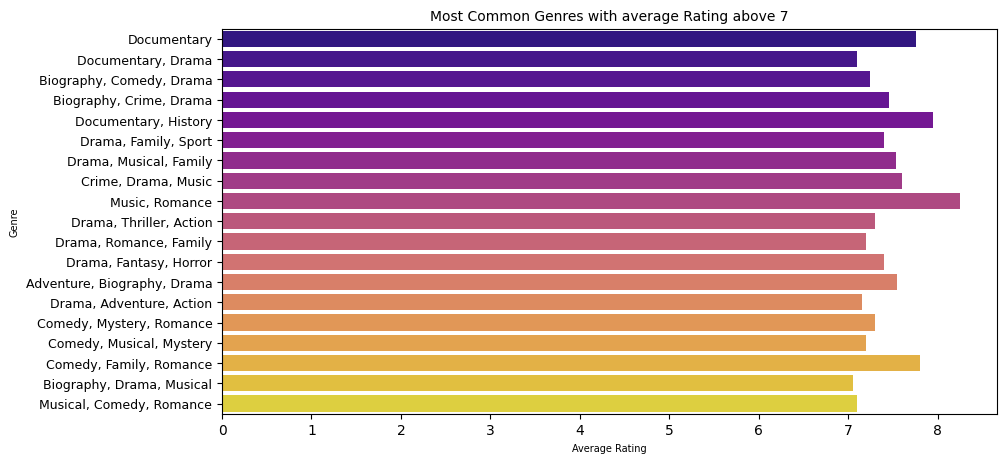

In [31]:
plt.figure(figsize=(10, 5))
sns.barplot(x='avg_rating', y='Genre', data=genre_stats_sorted, palette='plasma')

plt.title('Most Common Genres with average Rating above 7', fontsize=10)
plt.xlabel('Average Rating', fontsize=7)
plt.ylabel('Genre', fontsize=7)
plt.yticks(fontsize=9)

plt.show()

In [32]:
data.dtypes

Year          int32
Duration    float64
Genre        object
Rating      float64
Votes         int32
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [33]:
data.reset_index(drop=True, inplace=True)

In [34]:
data.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
2,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
3,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
4,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [35]:
data['Actor 3'].nunique()

2572

In [36]:
data.shape

(5688, 9)

### Feature Engineering

In [37]:
df = data.copy()

In [38]:
# target encoding with k-fold
def target_encoding(data, columns, target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = df[target].mean()

    for column in columns:
        encoded_col = np.zeros(len(df))

        for train_idx, val_idx in kf.split(df):
            train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
            avg_for_cols = train_fold.groupby(column)[target].mean()
            encoded_col[val_idx] = val_fold[column].map(avg_for_cols).fillna(global_mean)

        df[f"{column}_encoded"] = encoded_col  # make new columns
        df.drop(columns=[column], inplace=True)

    return df

In [39]:
col_to_encode = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
df = target_encoding(df, col_to_encode, target='Rating')

In [40]:
df.head()

,Year,Duration,Rating,Votes,Genre_encoded,Director_encoded,Actor 1_encoded,Actor 2_encoded,Actor 3_encoded
0,2019,109.0,7.0,8,6.421902,5.900738,6.700000,5.900738,5.900738
1,2019,110.0,4.4,35,5.747619,5.900738,6.066667,5.900738,4.500000
2,1997,147.0,4.7,827,6.258824,5.575000,4.607692,6.110000,5.800000
3,2005,142.0,7.4,1086,6.633333,7.300000,5.114286,5.900738,6.133333
4,2012,82.0,5.6,326,5.314286,5.900738,5.900738,5.975000,5.900738


In [41]:
df.drop(columns = 'Year', inplace = True)

### Train_Test split

In [42]:
# StandardScaler on Numerical Columns
scaler = StandardScaler()
numerical_cols = [col for col in df.columns if col not in ['Rating']]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [43]:
# Train-Test Split
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Prediction using LR

In [44]:
# Linear Regression using OLS
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     247.7
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          3.74e-313
Time:                        22:40:58   Log-Likelihood:                -7239.2
No. Observations:                4550   AIC:                         1.449e+04
Df Residuals:                    4542   BIC:                         1.455e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8775      0.018  

In [45]:
# calculate VIF for the model
vif = pd.DataFrame()
X = X_train
vif['Features']  = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Director_encoded,1.17
4,Actor 1_encoded,1.15
5,Actor 2_encoded,1.14
6,Actor 3_encoded,1.09
2,Genre_encoded,1.05
0,Duration,1.02
1,Votes,1.01


In [46]:
X_train.drop(columns ='Duration', inplace = True)

In [47]:
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     288.9
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          2.62e-314
Time:                        22:40:58   Log-Likelihood:                -7239.4
No. Observations:                4550   AIC:                         1.449e+04
Df Residuals:                    4543   BIC:                         1.454e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8777      0.018  

In [48]:
# calculate VIF for the model
vif = pd.DataFrame()
X = X_train
vif['Features']  = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Director_encoded,1.17
3,Actor 1_encoded,1.15
4,Actor 2_encoded,1.14
5,Actor 3_encoded,1.09
1,Genre_encoded,1.05
0,Votes,1.01


In [49]:
residuals = model.resid
print("Summary of Residuals:\n", model.summary())

Summary of Residuals:
                             OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     288.9
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          2.62e-314
Time:                        22:40:59   Log-Likelihood:                -7239.4
No. Observations:                4550   AIC:                         1.449e+04
Df Residuals:                    4543   BIC:                         1.454e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

In [50]:
# Predict on Test Set
X_test_new = X_test[X_train.columns]
X_test_const = sm.add_constant(X_test_new)
y_pred = model.predict(X_test_const)

Text(0, 0.5, 'y_pred')

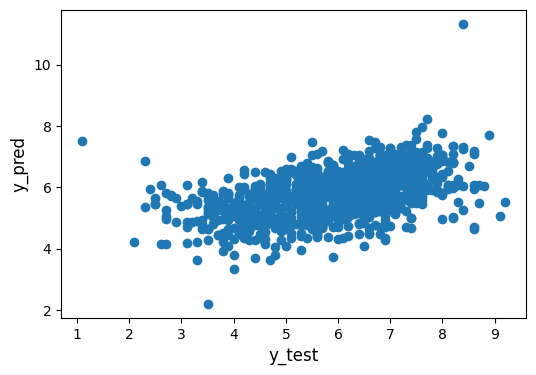

In [51]:
# Plotting y_test and y_pred to understand the spread.
plt.figure(figsize = [6,4])
plt.scatter(y_test,y_pred)
         
plt.xlabel('y_test', fontsize=12)                        
plt.ylabel('y_pred', fontsize=12)


In [52]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R² Score: {r2}")
print(f"Root Mean Squared Error: {rmse}")

R² Score: 0.235161325030962
Root Mean Squared Error: 1.14217441525072


### Prediction using RandomForestRegressor()

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Ensure X_test contains the same features as X_train
X_test_new = X_test[X_train.columns]

# Predict on the Test Set
y_pred_rf = rf_model.predict(X_test_new)

# Evaluate the Random Forest Model
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"R² Score: {r2_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")

R² Score: 0.2489965387009928
Root Mean Squared Error: 1.1317968394254967


### Prediction using Decision Tree Regressor

In [54]:
# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30]
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Ensure X_test contains the same features as X_train (since some columns might have been dropped)
X_test_new = X_test[X_train.columns]

# Predict on the Test Set
y_pred_dt = best_dt_model.predict(X_test_new)

# Evaluate the Decision Tree Model
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)

# Output the performance metrics and best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Decision Tree R² Score: {r2_dt}")
print(f"Decision Tree Root Mean Squared Error: {rmse_dt}")

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree R² Score: 0.2152563531284557
Decision Tree Root Mean Squared Error: 1.1569415320549552


#### Model Summary
-  All three models (Linear Regression, Random Forest, and Decision Tree) have low R² scores (ranging from 0.215 to 0.249), suggesting that none of the models are performing particularly well in predicting movie ratings. This could indicate that the relationships between the input features and the target variable are complex.
-  The RMSE values (ranging from 1.13 to 1.16) are similar across the three models, which means that the models are making fairly similar-sized errors on average when predicting the movie ratings.

#### Feature Significance:

-  Most features (Votes, Genre_encoded, Director_encoded, Actor 1_encoded, Actor 2_encoded, Actor 3_encoded) are statistically significant (p-values < 0.05).
-  Duration was not statistically significant (p-value = 0.512) and was removed from the model. This suggests that Duration does not have a strong linear relationship with Rating also can be seen during our EDA.
-  Director_encoded has the highest coefficient (0.318), indicating that directors have a substantial impact on the predicted rating.
-  Votes also contributes significantly (0.160), as expected; movies with more votes are likely better rated.